# Implementing a toy denoiser from scratch 

Implementing a toy denoiser for the MNIST dataset from scratch. 
The denoiser is trained on the MNIST dataset with added noise. 

(1) Get and prepare the data for training / validation 
(2) Define the model
(3) Train the model
(4) Evaluate the model

### TODO and log:
- Add all the bells and whistles for training monitoring 


In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
from datetime import datetime
import os
import logging

# Define experiment log directory and create it if it doesn't exist
log_dir = f'runs/denoiser_test_{datetime.now().strftime("%Y%m%d_%H:%M:%S")}'
os.makedirs(log_dir, exist_ok=True)

# Define experiment parameters
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Set up logging and add relevant information
logging.basicConfig(filename=os.path.join(log_dir, 'experiment.log'), 
                    level=logging.INFO, 
                    format=' %(message)s')
logging.info('Experiment started at {}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))
logging.info('Batch size: {}'.format(batch_size))
logging.info('Device: {}'.format(device))

Using cuda device


# Get and prepare the data for training / validation 

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print('Data loaders created')
print('Training data size: {}'.format(len(training_data)))
print('Test data size: {}'.format(len(test_data)))

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break



Data loaders created
Training data size: 60000
Test data size: 10000
Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


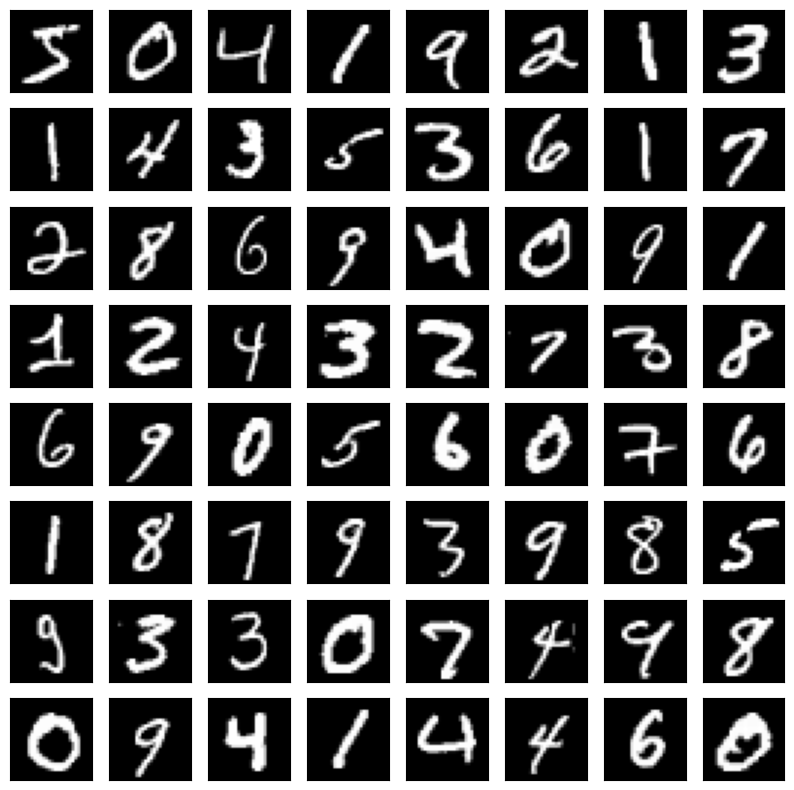

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show_batch(batch_of_images):
    imgs = [img for img in batch_of_images]
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    ncols = int(np.ceil(np.sqrt(len(imgs))))
    nrows = ncols
    fig, axs = plt.subplots(ncols=ncols, nrows=ncols, squeeze=False)
    fig.set_size_inches(10, 10)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i // ncols, np.mod(i,ncols)].imshow(np.asarray(img).squeeze(), cmap='gray')
        axs[i // ncols, np.mod(i,ncols)].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
show_batch(next(iter(train_dataloader))[0])

# Define the model


In [4]:
class bfcnn(nn.Module):
    "Bias-Free Convolutional Neural Network block"
    def __init__(self, chin=None, chout=32, kernel_size=3):
        super().__init__()
        self.bn = nn.BatchNorm2d(chin, affine=False)
        self.conv = nn.Conv2d(chin, chout, kernel_size, padding='same', bias=False) 
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.relu(x)
        return x
        

class Denoiser(nn.Module):
    "Bias free CNN denoiser, with 'depth' number of bfcnn blocks in"
    def __init__(self, depth=10):
        super().__init__()
        self.bfcnn_first = bfcnn(chin=1, chout=32, kernel_size=3)
        self.dfcnn_middle = nn.ModuleList(
            [bfcnn(chin=32, chout=32, kernel_size=3) for i in range(depth)]
            )
        self.bfcnn_last = bfcnn(chin=32, chout=1, kernel_size=3)
        self.dropout = nn.Dropout2d(p=0.5)
        self.depth = depth
        
    def forward(self, x):
        x = self.bfcnn_first(x)  # first bfccn block 1x28x28 -> 32x28x28
        for i in range(self.depth):
            x = self.dfcnn_middle[i](x)  # hidden bfcnn blocks 32x28x28 -> 32x28x28
        x = self.dropout(x)  ## dropout layer to prevent overfitting
        x = self.bfcnn_last(x)  # last bfcnn block 32x28x28 -> 1x28x28
        return x
    
denoiser = Denoiser(depth=5).to(device)
from torchsummary import summary
summary(denoiser, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 32, 28, 28]             288
              ReLU-3           [-1, 32, 28, 28]               0
             bfcnn-4           [-1, 32, 28, 28]               0
       BatchNorm2d-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]           9,216
              ReLU-7           [-1, 32, 28, 28]               0
             bfcnn-8           [-1, 32, 28, 28]               0
       BatchNorm2d-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 32, 28, 28]           9,216
             ReLU-11           [-1, 32, 28, 28]               0
            bfcnn-12           [-1, 32, 28, 28]               0
      BatchNorm2d-13           [-1, 32, 28, 28]               0
           Conv2d-14           [-1, 32,

In [5]:
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(denoiser.parameters(), lr=1e-3)

In [6]:
## Sanity check, understanding the loss
if 0:
    samples_batch, _ = next(iter(train_dataloader))
    # show_batch(samples_batch)
    x1 = samples_batch
    x0 = torch.zeros_like(x1)

    l = loss(x1, x0).item()  # loss between x1 and and a matrix of zeros
    print(f'Loss between x1 and x0: {l:>3f}')
    l2_x1 = np.sum(x1.detach().numpy()**2)/x1.numel()  # L2 norm of x1 normalized by the number of elements
    print(f"L2 norm of x1: {l2_x1:>3f}")
    # As we can see the loss is the L2 norm of x1 normalized by the number of elements
    # You can also verify it normalizes by the number of elements in the batch 

In [7]:
# Define tensorboard writer 
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

writer = SummaryWriter(log_dir=log_dir)

images, _ = next(iter(train_dataloader))  # grab images from a batch
img_grid = make_grid(images)  # create a grid of images
writer.add_image('images', img_grid)  # add the grid to the writer
writer.add_graph(denoiser, images.to(device))  # add the model to the writer

# Define tools to visualize examples. 
@torch.no_grad() 
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

@torch.no_grad() 
def plot_original_noisy_denoised_batches(o,n,d):
    images = torch.cat((o,n,d), dim=2)
    images = images.cpu()
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 6))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
    return fig
    


In [8]:
from torch.utils.tensorboard import SummaryWriter

def add_gaussian_noise(img, mean=0, std=None, stocastic=True):
    "If the noise std is not specified, is stocastic = True (default) it is set to be a random number between 0 and .4, otherwise is set to .1"
    if std is None:
        std = np.random.uniform(0, .4) if stocastic else .1
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return noisy_img


# We will check the model's performance against the test dataset to ensure it is learning 
@torch.no_grad()   # pythorch will not track the gradients in this block, reducing memory usage
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0 
    for X, _ in dataloader:
        noisy_X = add_gaussian_noise(X)
        X, noisy_X = X.to(device), noisy_X.to(device)
        pred = model(noisy_X)
        pred = pred.view(X.shape)  # reshape from 16x784 to 16x1x28x28
        test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches  # Mean MSE loss
    return test_loss
    
    
# Define training loop 
def train(train_dataloader, model, loss_fn, optimizer, epochs=10, 
          test_dataloader=None, writer=None):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        size = len(train_dataloader.dataset)
        model.train()
        for batch, (X, _) in enumerate(train_dataloader):
            noisy_X = add_gaussian_noise(X)  # noisy sample, 
            X, noisy_X = X.to(device), noisy_X.to(device)
            pred = model(noisy_X)  # denoised sample
            pred = pred.view(X.shape)  # reshape from 16x784 to 16x1x28x28
            loss = loss_fn(pred, X)   # MSE loss between denoised and original
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 50 == 0:
                loss, current = loss.item(), batch * len(X)
                if batch % 250 == 0: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                # ... log the running loss
                writer.add_scalar('training loss', loss, t*len(train_dataloader) + batch)
                writer.add_figure('original, noisy and denoised',
                                plot_original_noisy_denoised_batches(X, noisy_X, pred), 
                                global_step=t*len(train_dataloader) + batch)
                
        if test_dataloader is not None:  # add the test performance to the writer
            test_loss = test(test_dataloader, model, loss_fn)
            writer.add_scalar('test loss', test_loss, t*len(train_dataloader) + batch)
        

    

In [9]:
# Train the model
train(train_dataloader, denoiser, loss, optimizer, epochs=20, test_dataloader=test_dataloader, writer=writer)
test_loss = test(test_dataloader, denoiser, loss)
print(f"Test Avg loss: {test_loss:>8f} \n")
print("Done!")

# Save the model
filename = os.path.join(log_dir, "models", "model.pth")
torch.save(model.state_dict(), os.path.join(filename))
print(f"Saved PyTorch Model State to {filename}")

Epoch 1
-------------------------------
loss: 0.197860  [    0/60000]
loss: 0.012695  [ 3200/60000]
loss: 0.010542  [ 6400/60000]
loss: 0.007196  [ 9600/60000]
loss: 0.009474  [12800/60000]
loss: 0.010146  [16000/60000]
loss: 0.009511  [19200/60000]
loss: 0.008054  [22400/60000]
loss: 0.011514  [25600/60000]
loss: 0.005846  [28800/60000]
loss: 0.006202  [32000/60000]
loss: 0.005292  [35200/60000]
loss: 0.004455  [38400/60000]
loss: 0.007418  [41600/60000]
loss: 0.005795  [44800/60000]
loss: 0.006260  [48000/60000]
loss: 0.007566  [51200/60000]
loss: 0.004618  [54400/60000]
loss: 0.008124  [57600/60000]
Epoch 2
-------------------------------
loss: 0.010927  [    0/60000]
loss: 0.010912  [ 3200/60000]
loss: 0.010777  [ 6400/60000]
loss: 0.005167  [ 9600/60000]
loss: 0.003978  [12800/60000]
loss: 0.004845  [16000/60000]
loss: 0.006422  [19200/60000]
loss: 0.010499  [22400/60000]
loss: 0.007739  [25600/60000]
loss: 0.007793  [28800/60000]
loss: 0.008114  [32000/60000]
loss: 0.004128  [352

### Visualize some results 


In [12]:
def img_nomralize(img):
    img = img - img.min()
    img = img / img.max()
    return img

def batch_img_normalize(batch_of_imgs):
    for i in range(len(batch_of_imgs)):
        batch_of_imgs[i] = img_nomralize(batch_of_imgs[i])
    return batch_of_imgs

torch.Size([64, 1, 28, 28])


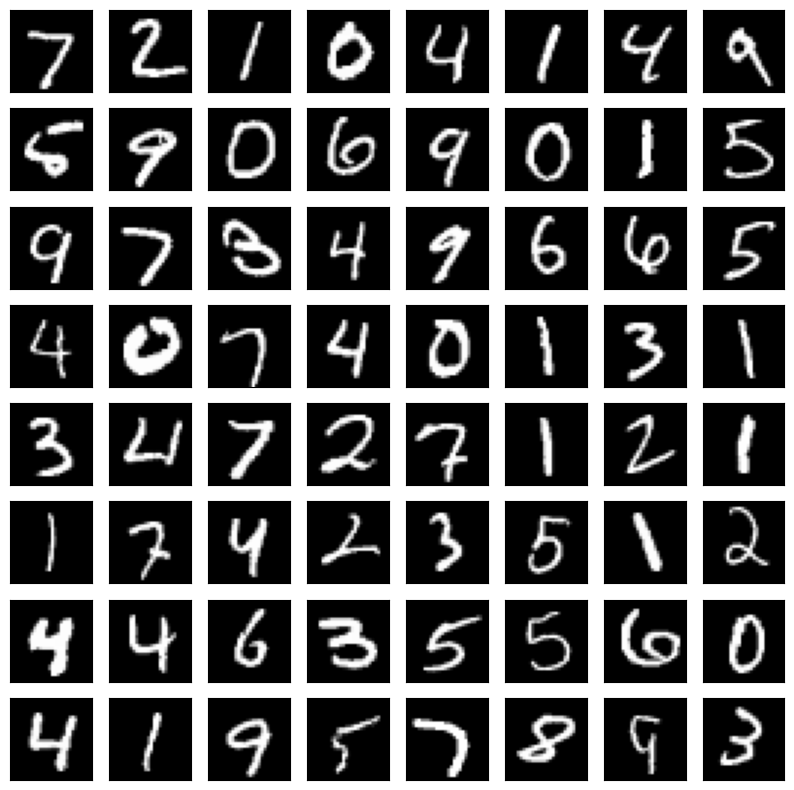

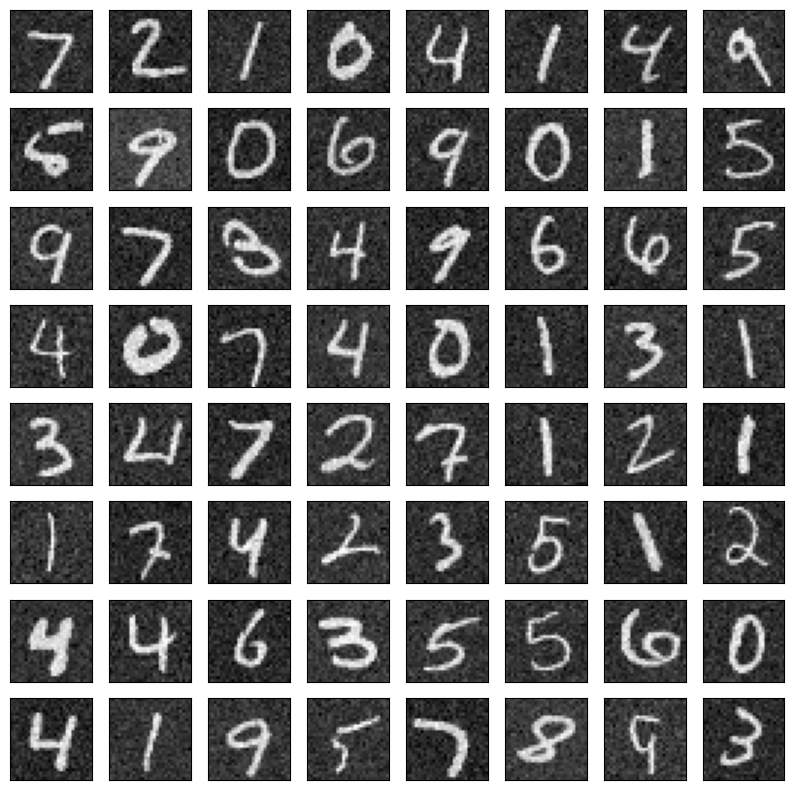

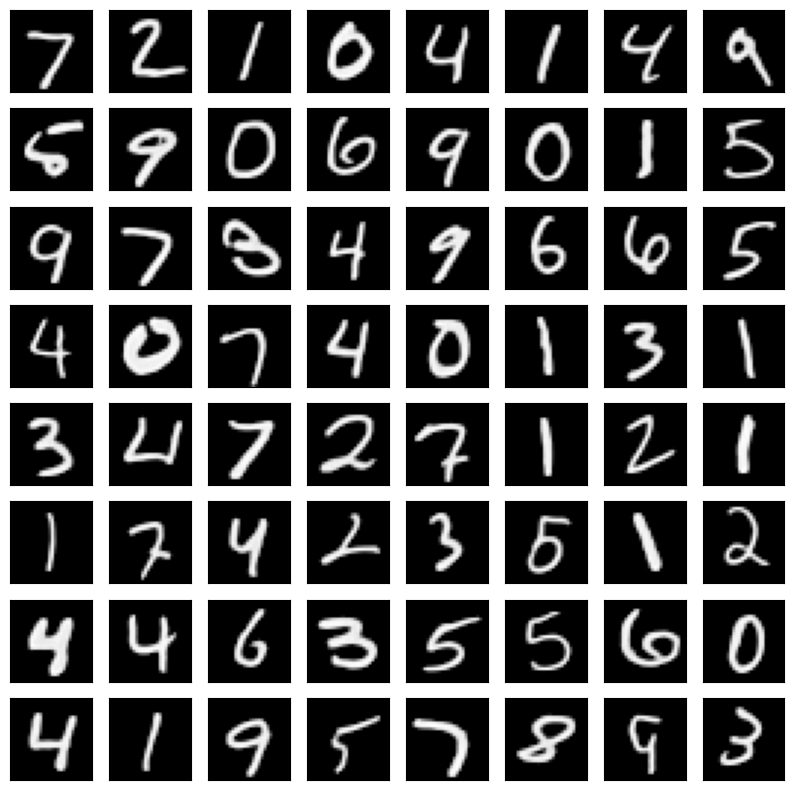

In [13]:
sample_batch = next(iter(test_dataloader))
X, _ = sample_batch
print(X.shape)

X_noisy = add_gaussian_noise(X)
X_noisy = batch_img_normalize(X_noisy)
X_denoised = denoiser(X_noisy.to(device))
X_denoised = X_denoised.view(X.shape).to('cpu')
X_noisy = X_noisy.to('cpu')

show_batch(X)
show_batch(batch_img_normalize(X_noisy))
show_batch(batch_img_normalize(X_denoised))
